<a href="https://colab.research.google.com/github/jenmusdat/Project3_BeerQuality/blob/main/Analysis/Jay_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

!echo "spark.driver.memory 5g" >> $SPARK_HOME/conf/spark-defaults.conf
!echo "spark.executor.memory 5g" >> $SPARK_HOME/conf/spark-defaults.conf
!echo "spark.driver.maxResultSize 5g" >> $SPARK_HOME/conf/spark-defaults.conf
!cat $SPARK_HOME/conf/spark-defaults.conf

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:13 https://developer.download.n

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Start a SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("word2vec").getOrCreate()
# MAX_MEMORY='5g'
# spark = SparkSession \
#     .builder \
#     .appName("word2vec") \
#     .config("spark.executor.memory", MAX_MEMORY) \
#     .config("spark.driver.memory", MAX_MEMORY) \
#     .getOrCreate()

In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11701766028923296263, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15505193728
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7119321033924957089
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"]

In [4]:
# Import needed libs
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.ml.feature import Word2Vec, Word2VecModel
import string


In [5]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="/content/gdrive/MyDrive/Project3_BeerQuality/Resources/reviews_beer_brewery.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("reviews_beer_brewery.csv"), header=True)

# Show DataFrame
df.show()

+-------+----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+--------------------+--------------------+----+----------+--------------------+---------------+-------------+-----------------+
|beer_id|        username|      date|                text|                look|               smell|               taste|                feel|             overall|               score|           beer_name|review_state|               style|        availability| abv|brewery_id|        brewery_name|   brewery_city|brewery_state|    brewery_types|
+-------+----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+--------------------+--------------------+----+----------+--------------------+-----------

In [6]:
# Check the schema for numeric conversion
df.printSchema

<bound method DataFrame.printSchema of DataFrame[beer_id: string, username: string, date: string, text: string, look: string, smell: string, taste: string, feel: string, overall: string, score: string, beer_name: string, review_state: string, style: string, availability: string, abv: string, brewery_id: string, brewery_name: string, brewery_city: string, brewery_state: string, brewery_types: string]>

In [7]:
df.count()

2127677

In [8]:
# remove alpha characters from data set on review numerics
from pyspark.sql.functions import regexp_extract, col
pattern = r'^\d+.\d+$'
df = df.filter(regexp_extract(col('look'), pattern, 0) != '')
df = df.filter(regexp_extract(col('smell'), pattern, 0) != '')
df = df.filter(regexp_extract(col('taste'), pattern, 0) != '')
df = df.filter(regexp_extract(col('feel'), pattern, 0) != '')
df = df.filter(regexp_extract(col('overall'), pattern, 0) != '')
df = df.filter(regexp_extract(col('score'), pattern, 0) != '')

In [9]:
# confirm look, smell, taste, overall, and score
df.show()

+-------+----------------+----------+--------------------+----+-----+-----+----+-------+-----+--------------------+------------+--------------------+--------------------+----+----------+--------------------+------------+-------------+-------------+
|beer_id|        username|      date|                text|look|smell|taste|feel|overall|score|           beer_name|review_state|               style|        availability| abv|brewery_id|        brewery_name|brewery_city|brewery_state|brewery_types|
+-------+----------------+----------+--------------------+----+-----+-----+----+-------+-----+--------------------+------------+--------------------+--------------------+----+----------+--------------------+------------+-------------+-------------+
| 271781|    bluejacket74|2017-03-17|   750 ml bottle,...| 4.0|  4.0|  4.0|4.25|    4.0| 4.03|Motorbreath Imper...|          OH|American Imperial...|Limited (brewed o...|10.8|     28094|Four String Brewi...|    Columbus|           OH| Brewery, Bar|
| 18

In [10]:
df.count()

1973273

In [11]:
# Next 6 lines casts to floats all the review ratings
df = df.withColumn('look_numeric', df['look'].cast('float'))
df = df.withColumn('smell_numeric', df['smell'].cast('float'))
df = df.withColumn('taste_numeric', df['taste'].cast('float'))
df = df.withColumn('feel_numeric', df['feel'].cast('float'))
df = df.withColumn('overall_numeric', df['overall'].cast('float'))
df = df.withColumn('score_numeric', df['score'].cast('float'))

In [12]:
# Confirm data types
df.printSchema

<bound method DataFrame.printSchema of DataFrame[beer_id: string, username: string, date: string, text: string, look: string, smell: string, taste: string, feel: string, overall: string, score: string, beer_name: string, review_state: string, style: string, availability: string, abv: string, brewery_id: string, brewery_name: string, brewery_city: string, brewery_state: string, brewery_types: string, look_numeric: float, smell_numeric: float, taste_numeric: float, feel_numeric: float, overall_numeric: float, score_numeric: float]>

In [13]:
# functions for manipulating review text into a format we can tokenize
def remove_punctuation(txt):
  txt = txt.strip('\xa0\xa0 ')
  return "".join(l if l not in string.punctuation else "" for l in txt)

def remove_space (text):
  if text:
    return text.replace(' ', '')
  else:
    return 'Unknown'
  

In [14]:
# define the udfs for the data
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, udf

remove_punctuation_udf = udf(remove_punctuation, StringType())
remove_punctuation_udf

remove_space_udf = udf(remove_space, StringType())
remove_space_udf

<function __main__.remove_space>

In [15]:
# clean the beer name by removing spaces (will be combined with text)
beer_df = df.withColumn('beer_clean', remove_space_udf(col('beer_name')))
beer_df.show()

+-------+----------------+----------+--------------------+----+-----+-----+----+-------+-----+--------------------+------------+--------------------+--------------------+----+----------+--------------------+------------+-------------+-------------+------------+-------------+-------------+------------+---------------+-------------+--------------------+
|beer_id|        username|      date|                text|look|smell|taste|feel|overall|score|           beer_name|review_state|               style|        availability| abv|brewery_id|        brewery_name|brewery_city|brewery_state|brewery_types|look_numeric|smell_numeric|taste_numeric|feel_numeric|overall_numeric|score_numeric|          beer_clean|
+-------+----------------+----------+--------------------+----+-----+-----+----+-------+-----+--------------------+------------+--------------------+--------------------+----+----------+--------------------+------------+-------------+-------------+------------+-------------+-------------+---

In [16]:
# clean the style name by removing spaces (will be combined with text)
style_df = beer_df.withColumn('style_clean', remove_space_udf(col('style')))
style_df.show()

+-------+----------------+----------+--------------------+----+-----+-----+----+-------+-----+--------------------+------------+--------------------+--------------------+----+----------+--------------------+------------+-------------+-------------+------------+-------------+-------------+------------+---------------+-------------+--------------------+--------------------+
|beer_id|        username|      date|                text|look|smell|taste|feel|overall|score|           beer_name|review_state|               style|        availability| abv|brewery_id|        brewery_name|brewery_city|brewery_state|brewery_types|look_numeric|smell_numeric|taste_numeric|feel_numeric|overall_numeric|score_numeric|          beer_clean|         style_clean|
+-------+----------------+----------+--------------------+----+-----+-----+----+-------+-----+--------------------+------------+--------------------+--------------------+----+----------+--------------------+------------+-------------+-------------+--

In [17]:
# clean the text by removing punctuation
text_df = style_df.withColumn("clean_text", remove_punctuation_udf(col("text")))
text_df.show()

+-------+----------------+----------+--------------------+----+-----+-----+----+-------+-----+--------------------+------------+--------------------+--------------------+----+----------+--------------------+------------+-------------+-------------+------------+-------------+-------------+------------+---------------+-------------+--------------------+--------------------+--------------------+
|beer_id|        username|      date|                text|look|smell|taste|feel|overall|score|           beer_name|review_state|               style|        availability| abv|brewery_id|        brewery_name|brewery_city|brewery_state|brewery_types|look_numeric|smell_numeric|taste_numeric|feel_numeric|overall_numeric|score_numeric|          beer_clean|         style_clean|          clean_text|
+-------+----------------+----------+--------------------+----+-----+-----+----+-------+-----+--------------------+------------+--------------------+--------------------+----+----------+--------------------+-

In [18]:
text_df = text_df.filter('clean_text != "0"')
text_df.count()

1938698

In [19]:
# Combine beer_name, style, and review text into a Final_text column
from pyspark.sql.functions import concat_ws

combined_df = text_df.withColumn('Final_text', concat_ws(' ',text_df.beer_clean, text_df.style_clean, text_df.clean_text))
combined_df.select('text', 'Final_text').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [20]:
# Setup and execute Tokenizer and Stop words pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline

# "Creating pipeline..."
tokenizer = Tokenizer(inputCol="Final_text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text', outputCol='features')

pipeline = Pipeline(stages=[tokenizer, stopremove])

# "Training model..."
pipeline_stg = pipeline.fit(combined_df)
final_df = pipeline_stg.transform(combined_df)
final_df.show()

+-------+----------------+----------+--------------------+----+-----+-----+----+-------+-----+--------------------+------------+--------------------+--------------------+----+----------+--------------------+------------+-------------+-------------+------------+-------------+-------------+------------+---------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|beer_id|        username|      date|                text|look|smell|taste|feel|overall|score|           beer_name|review_state|               style|        availability| abv|brewery_id|        brewery_name|brewery_city|brewery_state|brewery_types|look_numeric|smell_numeric|taste_numeric|feel_numeric|overall_numeric|score_numeric|          beer_clean|         style_clean|          clean_text|          Final_text|          token_text|            features|
+-------+----------------+----------+--------------------+----+-----+-----+----+--

In [21]:
# Create a df that had only the columns needed, leaving final text in this version for clustering later
compare_df = final_df.select('look_numeric', 'overall_numeric','features', 'Final_text')

In [22]:
compare_df.show()

+------------+---------------+--------------------+--------------------+
|look_numeric|overall_numeric|            features|          Final_text|
+------------+---------------+--------------------+--------------------+
|         4.0|            4.0|[motorbreathimper...|MotorbreathImperi...|
|         4.0|           3.75|[paybackpilsner, ...|PaybackPilsner Bo...|
|         4.0|            4.0|[paybackpilsner, ...|PaybackPilsner Bo...|
|        3.25|            3.5|[paybackpilsner, ...|PaybackPilsner Bo...|
|        3.75|            3.5|[paybackpilsner, ...|PaybackPilsner Bo...|
|        3.75|            3.5|[paybackpilsner, ...|PaybackPilsner Bo...|
|        3.75|            3.5|[paybackpilsner, ...|PaybackPilsner Bo...|
|        3.75|           3.75|[paybackpilsner, ...|PaybackPilsner Bo...|
|         4.5|           3.75|[paybackpilsner, ...|PaybackPilsner Bo...|
|         3.5|            3.5|[hellhammer, ryeb...|HELLHAMMER RyeBee...|
|        4.25|           4.25|[hellhammer, ryeb...|

In [ ]:
#
# Next 5 cells commented out because we already generated the model
#


#Create w2v model hyperparameters
# word2vec = Word2Vec(
#    vectorSize=65,
#    seed=42,
#    inputCol="features",
#    outputCol="model"
# ).setMaxIter(2)

In [ ]:
# Fit the model, this takes time
# w2v_review_model = word2vec.fit(final_df)

In [ ]:
# show some model vectors
# w2v_review_model.getVectors().show()

+--------------------+--------------------+
|                word|              vector|
+--------------------+--------------------+
|               mells|[0.02456387132406...|
|             tasties|[-0.1086105853319...|
|    sidebysidebyside|[0.19815589487552...|
|        morph3/10/15|[0.02991569414734...|
|              profle|[-0.0237566586583...|
|           professed|[-0.1994495540857...|
|            macdaddy|[0.02421975508332...|
|brewer'spaleale(n...|[-0.1731596291065...|
|               31211|[0.05593151971697...|
|palmettohopharves...|[-0.0290023237466...|
|  experimentalj-hole|[0.01752934418618...|
|          machfive55|[0.10892727226018...|
|              300day|[0.08266152441501...|
|          iteresting|[-0.0224218573421...|
|          fivehopipa|[-0.3549082279205...|
|               chary|[0.16387750208377...|
|          nonfruited|[-0.3561241030693...|
|       eyewateringly|[0.13200713694095...|
|100barrelseries#2...|[0.11839251220226...|
|               motts|[-0.177767

In [ ]:
# check the model accuracy by checking synonyms 
# w2v_review_model.findSynonymsArray("light", 5)

[('ligh', 0.709087073802948),
 ('medium', 0.7016751170158386),
 ('slight', 0.6841720342636108),
 ('mostly', 0.6569665670394897),
 ('mild', 0.6552731990814209)]

In [ ]:
# write the model to disk
# w2v_review_model.write().overwrite().save("/content/gdrive/MyDrive/Project3_BeerQuality/review.md")

In [23]:
# Read the model from disk to confirm
w2v_loaded_model = Word2VecModel.load('/content/gdrive/MyDrive/Project3_BeerQuality/review.md')

In [24]:
# check to see if synonym is consistent with loaded model
w2v_loaded_model.findSynonymsArray("light", 5)

[('ligh', 0.709087073802948),
 ('medium', 0.7016751170158386),
 ('slight', 0.6841720342636108),
 ('mostly', 0.6569665670394897),
 ('mild', 0.6552731990814209)]

In [25]:
# Transform the mode
w2v_model_df = w2v_loaded_model.transform(compare_df)

In [26]:
w2v_model_df.show()

+------------+---------------+--------------------+--------------------+--------------------+
|look_numeric|overall_numeric|            features|          Final_text|               model|
+------------+---------------+--------------------+--------------------+--------------------+
|         4.0|            4.0|[motorbreathimper...|MotorbreathImperi...|[0.08500721976638...|
|         4.0|           3.75|[paybackpilsner, ...|PaybackPilsner Bo...|[-0.0549288242537...|
|         4.0|            4.0|[paybackpilsner, ...|PaybackPilsner Bo...|[-0.0967330706055...|
|        3.25|            3.5|[paybackpilsner, ...|PaybackPilsner Bo...|[-0.0439293148062...|
|        3.75|            3.5|[paybackpilsner, ...|PaybackPilsner Bo...|[-0.0372556597539...|
|        3.75|            3.5|[paybackpilsner, ...|PaybackPilsner Bo...|[-0.0564575902186...|
|        3.75|            3.5|[paybackpilsner, ...|PaybackPilsner Bo...|[0.03651223104232...|
|        3.75|           3.75|[paybackpilsner, ...|PaybackPi

In [27]:
# Remove features to slim down the df (memory)
w2v_model_df = w2v_model_df.select('look_numeric','overall_numeric', 'model', 'Final_text')

In [28]:
#  Force the df into memory for faster processing
w2v_model_df.cache()
w2v_model_df.show()

+------------+---------------+--------------------+--------------------+
|look_numeric|overall_numeric|               model|          Final_text|
+------------+---------------+--------------------+--------------------+
|         4.0|            4.0|[0.08500721976638...|MotorbreathImperi...|
|         4.0|           3.75|[-0.0549288242537...|PaybackPilsner Bo...|
|         4.0|            4.0|[-0.0967330706055...|PaybackPilsner Bo...|
|        3.25|            3.5|[-0.0439293148062...|PaybackPilsner Bo...|
|        3.75|            3.5|[-0.0372556597539...|PaybackPilsner Bo...|
|        3.75|            3.5|[-0.0564575902186...|PaybackPilsner Bo...|
|        3.75|            3.5|[0.03651223104232...|PaybackPilsner Bo...|
|        3.75|           3.75|[-0.0623299623591...|PaybackPilsner Bo...|
|         4.5|           3.75|[-0.1056468814562...|PaybackPilsner Bo...|
|         3.5|            3.5|[0.04035126550833...|HELLHAMMER RyeBee...|
|        4.25|           4.25|[0.07892359918914...|

In [32]:
# just grab what you need for linear regression
split_df = w2v_model_df.select('look_numeric', 'overall_numeric', 'model')

In [33]:
# split training and testing for the model (for temporary make the training set small as processing takes time)
training, testing = split_df.randomSplit([0.60, 0.40])

In [34]:
training.show()

+------------+---------------+--------------------+
|look_numeric|overall_numeric|               model|
+------------+---------------+--------------------+
|         1.0|            1.0|[-0.1785312250256...|
|         1.0|            1.0|[-0.1417717045793...|
|         1.0|            1.0|[-0.1349599064560...|
|         1.0|            1.0|[-0.1342195305579...|
|         1.0|            1.0|[-0.1236223436315...|
|         1.0|            1.0|[-0.1097166956254...|
|         1.0|            1.0|[-0.1087134091345...|
|         1.0|            1.0|[-0.1014434211645...|
|         1.0|            1.0|[-0.0953985046814...|
|         1.0|            1.0|[-0.0920113995671...|
|         1.0|            1.0|[-0.0885817385760...|
|         1.0|            1.0|[-0.0822320045395...|
|         1.0|            1.0|[-0.0715544730546...|
|         1.0|            1.0|[-0.0654570498736...|
|         1.0|            1.0|[-0.0583876844902...|
|         1.0|            1.0|[-0.0572307807289...|
|         1.

In [35]:
# Convert the df to pandas to use sklearn
training_pandas_df = training.toPandas()

In [36]:
# Show the pandas df
training_pandas_df.head()

,look_numeric,overall_numeric,model
0,1.0,1.0,"[-0.17853122502565383, -0.1287376307727148, 0...."
1,1.0,1.0,"[-0.14177170457939306, 0.0349507103053232, 0.0..."
2,1.0,1.0,"[-0.1349599064560607, 0.12372833413870206, -0...."
3,1.0,1.0,"[-0.13421953055792704, 0.024024348831153477, -..."
4,1.0,1.0,"[-0.12362234363154995, 0.05039873202553107, -0..."


In [37]:
training_pandas_df.dtypes

look_numeric       float32
overall_numeric    float32
model               object
dtype: object

In [38]:
# Create the linear regression model
from sklearn.linear_model import LinearRegression
pandas_lin_model = LinearRegression()

In [39]:
# Fit the overall rating into the model
lin_overall_train_model = pandas_lin_model.fit(training_pandas_df['model'].to_list(),training_pandas_df['overall_numeric'])

In [40]:
# Verify the score, very low so no strong correlation between w2v model and overall rating
lin_overall_train_model.score(training_pandas_df['model'].to_list(), training_pandas_df['overall_numeric'])

0.3491301422087078

In [41]:
# Show the coeficients
lin_overall_train_model.coef_

array([-0.69585687,  1.18759938,  0.87410988, -0.79770162, -0.17794098,
        0.55989595,  0.84156102,  0.730863  , -0.25688357, -0.17424912,
        0.61456547,  0.15393584, -0.96462055, -0.4744158 , -0.79723212,
       -0.64494915, -1.40584679, -0.1507007 ,  0.24811762,  0.50383521,
       -1.05371082, -0.63491712, -0.40003509,  0.20969716,  0.46898767,
       -1.17943397, -1.58544424, -0.43305716, -0.03468737,  0.77595567,
        0.59073617,  0.43786618,  0.50891617,  1.19431703, -0.17276113,
        0.71205297,  0.01487068, -0.48133325, -0.66316492,  0.59481679,
       -0.03893024, -0.81252012, -1.07985651,  0.52481667,  1.99789896,
       -0.30603677, -0.13997984, -0.09007413, -0.13698908,  0.6544296 ,
        0.62796751,  0.83592069,  0.67956386,  0.26528298,  0.253423  ,
        1.09008225,  1.14154347, -0.30763261, -1.45297499, -0.33523512,
        1.86986242,  0.65389752,  0.01026717,  0.25714838,  0.2249784 ])

In [42]:
# Fit the model for the look rating
lin_look_train_model = pandas_lin_model.fit(training_pandas_df['model'].to_list(),training_pandas_df['look_numeric'])

In [43]:
# Get the score for the look rating
lin_look_train_model.score(training_pandas_df['model'].to_list(), training_pandas_df['look_numeric'])

0.27892288111071006

In [44]:
# Show the coeficients
lin_look_train_model.coef_

array([-0.7261086 ,  0.505411  ,  1.04127882,  0.04706063, -0.57991636,
       -0.3483765 ,  0.48818357, -0.03613169, -0.22569531, -0.35567402,
        0.47475282, -0.2238947 , -0.47357418, -0.15995659, -0.9845863 ,
       -0.39994868, -1.15039595,  0.22735304, -0.08339057,  0.11882715,
       -0.86286112, -0.15645653, -0.09623317,  0.16020427,  0.26412967,
       -1.1499025 , -0.89829232, -0.44031968,  0.16238797,  1.01235913,
        0.11210169,  0.1504161 ,  0.3279356 ,  0.42792285, -0.03504498,
        0.60308256, -0.10626095,  0.19793015, -0.07026071,  0.28238646,
       -0.35515652, -0.65813416, -0.92767758,  0.42384621,  1.58487162,
       -0.12841685, -0.36688886,  0.18436444,  0.11549192,  0.25076603,
        0.57912223, -0.09576435, -0.05053029,  0.10329511,  0.35382911,
        0.87160592,  0.52181812, -0.2688648 , -0.50404749, -0.32023944,
        1.56645117,  0.27793096, -0.07124536, -0.03838714,  0.01384959])

In [ ]:
#
# Commented out since we are going to use sklearn and pandas (processing was to slow for spark)
#
#  even at 1% on the training data
#

# Prepare the hyperparameters
#from pyspark.ml.regression import LinearRegression, LinearRegressionModel
#lin_model = LinearRegression(
#    maxIter=5,
#    regParam=0.3,
#    featuresCol="model",
#    labelCol="look_numeric"
#)

In [ ]:
# Fit the look review to a model (takes time)
#lin_look_train_model = lin_model.fit(training)

In [ ]:
# Save the model for later use
#lin_look_train_model.write().overwrite().save("/content/gdrive/MyDrive/Project3_BeerQuality/lin_look_train.md")

In [ ]:
# Read the model
#loaded_lin_look_train_model = LinearRegressionModel.load("/content/gdrive/MyDrive/Project3_BeerQuality/lin_look_train.md")

In [ ]:
# Transform the training data to peek at the predictions
#lin_look_df = loaded_lin_look_train_model.transform(training)

In [ ]:
# show a sample of the predictions
#lin_look_df.select('look_numeric', 'prediction', 'Final_text').show(truncate=False)

+------------+------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [29]:
# Prepare the cluster dataframe
w2v_cluster = w2v_model_df.select('Final_text', 'model').withColumnRenamed("model","features").withColumnRenamed("Final_text", "text")
w2v_cluster.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [30]:
# Run a PCA to bucketize our 65 vectors down to 10 
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors

#pca = PCA(k=10, inputCol="features", outputCol="pcaFeatures")
#pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(w2v_cluster)
result = model.transform(w2v_cluster)
result.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [31]:
# Rename pcaFeatures to features for the k-means processing
result = result.select("text", "pcaFeatures")
w2v_cluster = result.withColumnRenamed("pcaFeatures", "features")
w2v_cluster.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [32]:
# Create the k-means and fit the model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a k-means model.
kmeans = KMeans().setK(5).setSeed(1)
km_model = kmeans.fit(w2v_cluster)


ctr=[]
centers = km_model.clusterCenters()
for center in centers:
    ctr.append(center)
    print(center)

[-0.22683187 -0.23068124 -0.07904145]
[ 0.56565343 -0.2916108   0.08007113]
[ 0.18608622 -0.03979039 -0.12157193]
[-0.08553791 -0.09085624 -0.13984483]
[-0.13984907  0.00645873  0.0862545 ]


In [33]:
# Make predictions
predictions = km_model.transform(w2v_cluster)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(distanceMeasure="cosine")


# silhouette score goes between -1, 1. 1 is better. Negative is bad
silhouette = evaluator.evaluate(predictions)
print("Silhouette with cosine distance = " + str(silhouette))

Silhouette with cosine distance = 0.22347123601622254


In [34]:
predictions.show()

+--------------------+--------------------+----------+
|                text|            features|prediction|
+--------------------+--------------------+----------+
|MotorbreathImperi...|[0.07419711796419...|         4|
|PaybackPilsner Bo...|[-0.0938131412243...|         0|
|PaybackPilsner Bo...|[0.35178409067082...|         2|
|PaybackPilsner Bo...|[-0.2783645308527...|         0|
|PaybackPilsner Bo...|[0.21345624891097...|         2|
|PaybackPilsner Bo...|[0.03946162724271...|         3|
|PaybackPilsner Bo...|[-0.1672441628652...|         0|
|PaybackPilsner Bo...|[0.00281932689372...|         3|
|PaybackPilsner Bo...|[0.14746525498594...|         2|
|HELLHAMMER RyeBee...|[0.00732935077190...|         3|
|HELLHAMMER RyeBee...|[0.06522947150919...|         2|
|VanillaPorter Ame...|[0.34651795411143...|         1|
|VanillaPorter Ame...|[-0.1347499418325...|         4|
|VanillaPorter Ame...|[0.51230923682130...|         1|
|VanillaPorter Ame...|[0.00865305619016...|         4|
|VanillaPo

In [35]:
#predictions.select("prediction").distinct()

gr = predictions.orderBy('prediction').groupBy("prediction").count()
gr.show()

+----------+------+
|prediction| count|
+----------+------+
|         0|457273|
|         1| 74436|
|         2|399846|
|         3|572710|
|         4|434433|
+----------+------+



In [36]:
# See if the predicted grouping seeing logical
predictions.select('prediction', 'text').filter("prediction=4").show(100, truncate=False)

+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [38]:
# Grab pandas df to plot
pandas_predictions_df = predictions.select('features','prediction').toPandas()

In [39]:
#write_df = predictions.select('text','prediction')
#write_df.repartition(1).write.csv('/content/gdrive/MyDrive/Project3_BeerQuality/mycsv.csv', header=True)

In [40]:
# Create x, y, z from features
import pandas as pd
#pandas_predictions_df['x'], pandas_predictions_df['y'] = zip(*pandas_predictions_df['features'])
pandas_predictions_df['x'], pandas_predictions_df['y'], pandas_predictions_df['z'] = zip(*pandas_predictions_df['features'])


In [41]:
pandas_predictions_df.head()

,features,prediction,x,y,z
0,"[0.07419711796419273, -0.06255635429823621, 0....",4,0.074197,-0.062556,0.144041
1,"[-0.09381314122433464, -0.3842175652727937, -0...",0,-0.093813,-0.384218,-0.059686
2,"[0.3517840906708287, -0.11101807599975443, -0....",2,0.351784,-0.111018,-0.291645
3,"[-0.2783645308527124, -0.2631967219586216, -0....",0,-0.278365,-0.263197,-0.168032
4,"[0.21345624891097859, 0.006669429071162434, -0...",2,0.213456,0.006669,-0.173560


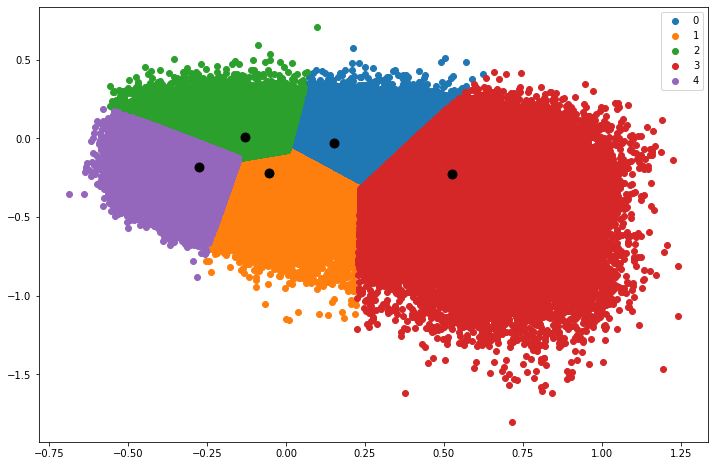

In [ ]:

# import matplotlib.pyplot as plt
# fig=plt.figure(figsize=(12,8))
# for i in range(5):
#     plt.scatter(pandas_predictions_df[pandas_predictions_df["prediction"] == i]['x'] , pandas_predictions_df[pandas_predictions_df["prediction"] == i]['y'], label=i)
#     plt.scatter(ctr[i][0] , ctr[i][1], s = 80, color = 'black')
# plt.legend()    
# plt.show()

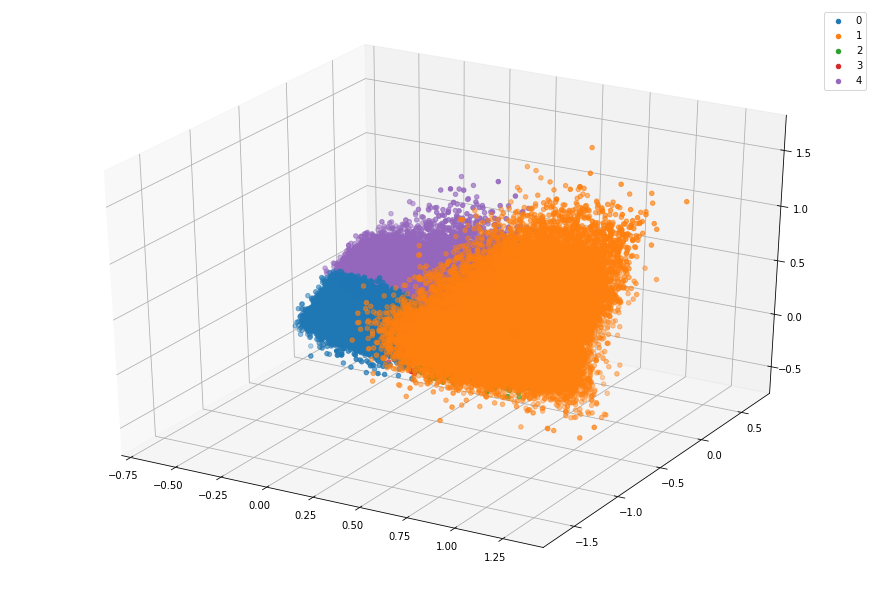

In [42]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
   
fig=plt.figure(figsize=(12,8))
ax=Axes3D(fig)
for i in range(5):
    ax.scatter(pandas_predictions_df[pandas_predictions_df["prediction"] == i]['x'] , pandas_predictions_df[pandas_predictions_df["prediction"] == i]['y'],  pandas_predictions_df[pandas_predictions_df["prediction"] == i]['z'], label=i)
for i in range(5):
    ax.scatter(ctr[i][0] , ctr[i][1] , ctr[i][2], s = 160, color = 'black')
plt.legend()    
plt.show()  

In [ ]:
# Just looking at spark parameters
print(spark.sparkContext.defaultParallelism)

2


In [ ]:
# More spark params
s = spark.sparkContext._jsc.sc().getExecutorMemoryStatus().keys()
print(s)
l = str(s).replace("Set(","").replace(")","").split(", ")
print(l)

d = set()
for i in l:
    d.add(i.split(":")[0])
print(len(d))

print(spark.sparkContext._jsc.sc().getExecutorMemoryStatus().size())

Set(492190d9606c:38029)
['492190d9606c:38029']
1
1


In [ ]:
# Get the spark config
spark.sparkContext._conf.getAll() 

[('spark.driver.host', 'f2e9c2339494'),
 ('spark.driver.memory', '4g'),
 ('spark.rdd.compress', 'True'),
 ('spark.executor.memory', '4g'),
 ('spark.driver.port', '40021'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1615496275942'),
 ('spark.app.name', 'word2vec'),
 ('spark.ui.showConsoleProgress', 'true')]

In [ ]:
# Look at vm os to get the number of cores
!cat /proc/cpuinfo

processor	: 0
vendor_id	: AuthenticAMD
cpu family	: 23
model		: 49
model name	: AMD EPYC 7B12
stepping	: 0
microcode	: 0x1000065
cpu MHz		: 2250.000
cache size	: 512 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid extd_apicid tsc_known_freq pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm cmp_legacy cr8_legacy abm sse4a misalignsse 3dnowprefetch osvw topoext ssbd ibrs ibpb stibp vmmcall fsgsbase tsc_adjust bmi1 avx2 smep bmi2 rdseed adx smap clflushopt clwb sha_ni xsaveopt xsavec xgetbv1 clzero xsaveerptr arat npt nrip_save umip rdpid
bugs		: sysret_ss_attrs spectre_v1 spectre_v2 spec_store_bypass
bogomips	: 4500.00
TLB size	: 307

In [ ]:
# Look at vm os to get memory size
!cat /proc/meminfo

MemTotal:       13333568 kB
MemFree:          373764 kB
MemAvailable:   11164900 kB
Buffers:          115264 kB
Cached:         10581148 kB
SwapCached:            0 kB
Active:          4418788 kB
Inactive:        8105484 kB
Active(anon):    1701420 kB
Inactive(anon):      360 kB
Active(file):    2717368 kB
Inactive(file):  8105124 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               968 kB
Writeback:             0 kB
AnonPages:       1827760 kB
Mapped:           140948 kB
Shmem:              1124 kB
Slab:             336356 kB
SReclaimable:     294532 kB
SUnreclaim:        41824 kB
KernelStack:        5716 kB
PageTables:         9956 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666784 kB
Committed_AS:    5137308 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:             1024 kB
AnonHugePages:   

In [ ]:
# Look for the spark java process to get memory config
!ps -ef | grep java

root        1185      59 35 20:57 ?        00:13:34 /usr/lib/jvm/java-8-openjdk-amd64/bin/java -cp /content/spark-2.4.7-bin-hadoop2.7/conf/:/content/spark-2.4.7-bin-hadoop2.7/jars/* -Xmx4g org.apache.spark.deploy.SparkSubmit --conf spark.executor.memory=4g --conf spark.driver.memory=4g --conf spark.app.name=word2vec pyspark-shell
root        2251      59  0 21:36 ?        00:00:00 /bin/bash -c ps -ef | grep java
root        2253    2251  0 21:36 ?        00:00:00 grep java
